In [1]:
%matplotlib inline

In [37]:
import os
import networkx as nx
import pickle as pkl
import pandas  as pd
from glob import glob
from graph_tool import load_graph, GraphView
from graph_tool.all import global_clustering
from helpers import cascade_source, infected_nodes

from collections import Counter
from tqdm import tqdm

In [3]:
def draw_for_graph(graph, stat_extractor):
    dataset_id = '{}-msi-s0.1-o0.1-omuniform/'.format(graph)
    cascade_path_patterns = os.path.join('cascade-with-edges/', dataset_id, '*.pkl')    
    
    cascades = [pkl.load(open(p, 'rb')) for p in glob(cascade_path_patterns)]
    
    depths = []
    for _, c, edges in tqdm(cascades):
        source = cascade_source(c)

        g = nx.Graph()
        g.add_edges_from(edges)
        depths += stat_extractor(g, source)    
    df = pd.DataFrame(depths)
    df.hist()

In [4]:
def extract_depths(g, source):
    return list(nx.shortest_path_length(g, source=source).values())    

In [5]:
def extract_degs(g, source):
    return list(nx.degree(g).values())    

In [6]:
def wiener_index(g, *args):
    return [nx.algorithms.wiener.wiener_index(g)]

In [16]:
def extract_tree_depth(g, source):
    return [max(extract_depths(g, source))]

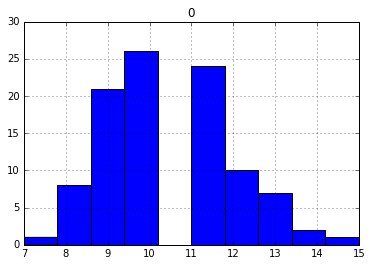

In [17]:
draw_for_graph('grqc', extract_tree_depth)

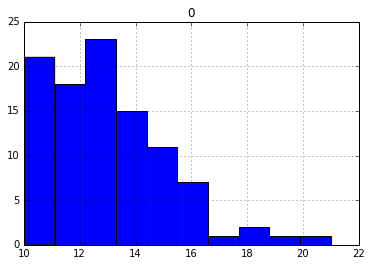

In [20]:
draw_for_graph('lattice-1024', extract_tree_depth)

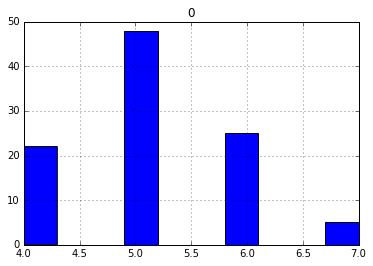

In [19]:
draw_for_graph('fb-messages', extract_tree_depth)

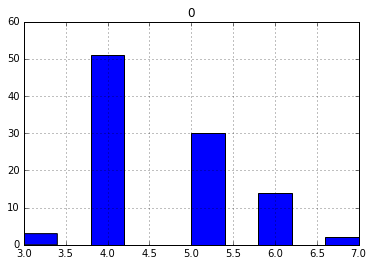

In [18]:
draw_for_graph('infectious', extract_tree_depth)

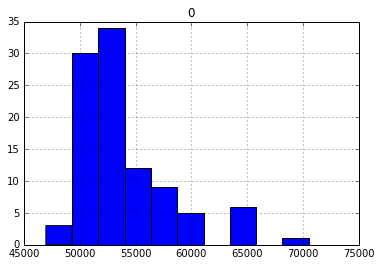

In [7]:
draw_for_graph('lattice-1024', wiener_index)

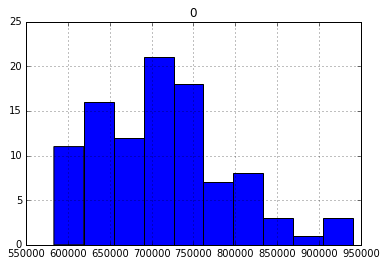

In [11]:
draw_for_graph('grqc', wiener_index)

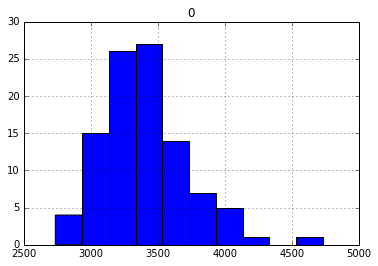

In [12]:
draw_for_graph('infectious', wiener_index)

In [57]:
def stats_for_graph(graph, func):
    g = load_graph('data/{}/graph.gt'.format(graph))
    
    dataset_id = '{}-msi-s0.1-o0.1-omuniform/'.format(graph)
    cascade_path_patterns = os.path.join('cascade/', dataset_id, '*.pkl')    
    
    cascades = [pkl.load(open(p, 'rb')) for p in glob(cascade_path_patterns)]
    
    stats = []
    for _, c in cascades:
        inf_nodes = infected_nodes(c)
        vfilt = g.new_vertex_property('bool')
        vfilt.a = False
        vfilt.a[inf_nodes] = True
        subg = GraphView(g, vfilt=vfilt)
        stats.append(func(subg))
    df = pd.Series(stats)
    return df.describe()
    # df.hist()

In [58]:
graphs = ['lattice-1024', 'infectious', 'fb-messages', 'email-univ', 'grqc']

In [59]:
for graph in graphs:
    print(graph, stats_for_graph(graph, lambda g: global_clustering(g)[0])['mean'])

lattice-1024 0.0
infectious 0.5303511944801272
fb-messages 0.08739802560816524
email-univ 0.2618482750951399
grqc 0.7350589235172901


In [60]:
def density(g):
    return 2 * g.num_edges() / g.num_vertices() / (g.num_vertices() - 1)

for graph in graphs:
    print(graph, stats_for_graph(graph, density)['mean'])

lattice-1024 0.03318865410241766
infectious 0.22103658536585372
fb-messages 0.054471941007374076
email-univ 0.05891942244993013
grqc 0.023628938832252085
